In [47]:
# !pip install memory-profiler
%load_ext memory_profiler

# !pip install bitarray
from bitarray import bitarray

import datetime

import numpy as np
import matplotlib.pyplot as plt

import random

import time

import gc

import sys

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Memory usage

###  Arrays

#### Built-in array of integers

In [2]:
a = [1]*1000
sys.getsizeof(a)

8056

#### Built-in array of booleans

In [3]:
b = [True]*1000
sys.getsizeof(b)

8056

#### Bitarray

In [4]:
c = bitarray('1'*1000)
sys.getsizeof(c)

216

### Matrices

#### Built-in matrix of integers

In [5]:
N = 1000
M = 1000

In [6]:
a = [[1]*M for _ in range(N)]
print("Size of a, Size of a[0]")
sys.getsizeof(a), sys.getsizeof(a[0])

Size of a, Size of a[0]


(8856, 8056)

#### Built-in matrix of booleans

In [7]:
b = [[True]*M for _ in range(N)]
print("Size of b, Size of b[0]")
sys.getsizeof(b), sys.getsizeof(b[0])

Size of b, Size of b[0]


(8856, 8056)

#### Bitarray matrix

In [8]:
c = [bitarray('1'*M) for _ in range(N)]
print("Size of c, Size of c[0]")
sys.getsizeof(c), sys.getsizeof(c[0])

Size of c, Size of c[0]


(8856, 216)

In [9]:
path = "./"
path_out = "./"

In [10]:
class Matrix:
    def __init__(self, data):
        self.data = data
        self.rows = len(data)
        self.cols = len(data[0]) if self.rows > 0 else 0

In [11]:
def count_comment_lines(filename):
    with open(filename, 'r') as f:
        return sum(1 for line in f if line.startswith(";;;"))

In [12]:
def count_total_lines(filename):
    with open(filename, 'r') as f:
        return sum(1 for line in f)

In [13]:
def detect_columns(filename, offset):
    with open(filename, 'r') as f:
        for _ in range(offset):
            next(f)  # skip lines
        line = next(f).strip().split()
        return len(line) - 1  # excluding the trailing "-"

In [14]:
def read_file(filename, rows, cols, offset):
    with open(filename, 'r') as f:
        for _ in range(offset):
            next(f)  # skip lines

        data = []
        for k in range(rows):
            line = next(f, None)
            if line is None:
                break
            numbers = list(map(int, line.strip().split()[:-1]))  # excluding the trailing "-"
            
            if len(numbers) != cols:
                break
                
            bit_string = ''.join(map(str, numbers))
            numbers = bitarray(bit_string)
            
            data.append(numbers)

        # printing in 2d matrix format data:
        # for row in data:
        #     for col in row:
        #         print(col, end=" ")
        #     print()

        return Matrix(data)


def read_rows_from_file(filename, cols, offset, list_idx_2_read):
    with open(filename, 'r') as f:
        for _ in range(offset):
            next(f)

        # To keep track of the index of the row in the file,
        # we save a tuple containing the index and the row
        data = []

        # This time we don't have a block of rows to read
        # but we have to read all the rows until the last one
        # contained in list_ix_2_read, so we could range over
        # the maximum of list_idx_2_read
        for k in range(max(list_idx_2_read) + 1):
            line = next(f, None)
            if line is None:
                break
            if k in list_idx_2_read:
                numbers = list(map(int, line.strip().split()[:-1]))
                if len(numbers) != cols:
                    print("Error: wrong number of columns in row", k)
                    break
                    
                bit_string = ''.join(map(str, numbers))
                numbers = bitarray(bit_string)
                data.append((k, numbers))
        return data

In [15]:
# Returns True if two rows have a common '1', else False
def intersect(row1, row2):
    return (row1 & row2).any()

# Return the union of two rows (bitwise OR)
def union(row1, row2):
    return row1 | row2

In [16]:
def EC(A, B, COV, offset, FILE_NAME, LOADABLE_ROWS, explored=[], max_explorations=-1):
    N = A.rows
    M = A.cols

    # Size of A
    # print("Size of A: ", sys.getsizeof(A.data), sys.getsizeof(A.data[0]))

    # Size of B
    # print("Size of B: ", sys.getsizeof(B), sys.getsizeof(B[0]))

    comment_lines = count_comment_lines(FILE_NAME)
    # exploration_times = []

    for i in range(N):
        row_data = A.data[i]


        if sum(row_data) == 0:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0
            continue

        explored.append((offset + i,))

        if sum(row_data) == M:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0
            COV.add((offset + i,))
            continue

        reading_offset = 0
        # For testing purposes, let's set LOADAABLE_ROWS to 1
        # LOADABLE_ROWS = 1
        # Using LOADABLE_ROWS=1 makes everything fast even when
        # LOADABLE_ROWS outside of this function is large,
        # so the problems that LOADABLE_ROWS being large generates
        # are only in here, but the good thing is that we can actually
        # set a LOADABLE_ROWS inside here and a different one outside!
        # UPDATE!!  
        # It's LOADABLE_ROWS used inside explore() that matters, not the one used
        # inside the while loop by itself, se we can just pass 1 instead of LOADABLE_ROWS
        # to explore and keep the larger one here!
        while reading_offset < i + offset:

            old_A = read_file(FILE_NAME, LOADABLE_ROWS, M, reading_offset+comment_lines)
            # Size of old_A
            # print("Size of old_A: ", sys.getsizeof(old_A.data), sys.getsizeof(old_A.data[0]))

            for j in range(min(old_A.rows, i + offset - reading_offset)):

                explored.append((offset + i, j + reading_offset))

                old_row_data = old_A.data[j]

                if sum(old_row_data) in [0, M]:
                    continue

                if intersect(old_row_data, row_data):
                    B[j + reading_offset][i + offset] = 0
                else:
                    I = (offset + i, j + reading_offset)
                    U = union(old_row_data, row_data)
                    if sum(U) == M:
                        COV.add(tuple(sorted(I)))
                        B[j + reading_offset][i + offset] = 0
                    else:
                        B[j + reading_offset][i + offset] = 1
                        inter = [k for k in range(j + reading_offset) if B[k][i + offset] and B[k][j + reading_offset]]
                        if inter:
                            k_A = read_rows_from_file(FILE_NAME, M, comment_lines, inter)

                            # Size of k_A
                            # print("Size of k_A: ", sys.getsizeof(k_A), sys.getsizeof(k_A[0]))
                            
                            # print("inter from EC: ", inter)
                            # print("k_A from EC: ", k_A)
                            # k_A is a list of tuples (index, row)
                            # start_explore_time = datetime.datetime.now()
                            explore(I, U, inter, COV, k_A, B, offset, old_A.cols, FILE_NAME, 1, explored, max_explorations)
                            if max_explorations != -1 and len(explored) >= max_explorations:
                                print("Max explorations reached")
                                print("I: ", I)
                                print("COV:", COV)
                                return COV
                            # end_explore_time = datetime.datetime.now()
                            # exploration_times.append(end_explore_time - start_explore_time)
            # del old_A
            reading_offset += LOADABLE_ROWS

    # if len(exploration_times) > 0:
        # print("Number of started explorations: ", len(exploration_times))
        # print("Average exploration time: ", sum(exploration_times, datetime.timedelta(0)) / len(exploration_times))
    # gc.collect()

    # Size of COV
    # print("Size of COV: ", sys.getsizeof(COV))
    return COV


def explore(I, U, inter, COV, k_A, B, offset, M, FILE_NAME, LOADABLE_ROWS=1, explored=[], max_explorations=-1):
    if max_explorations != -1 and len(explored) >= max_explorations:
        # print("Max explorations reached")
        # print("I: ", I)
        # print("COV:", COV)
        return

    # if I in explored:
    #     print("Already explored")
    #     return

    # Growing the list of explored sets
    if explored[-1] != tuple(I):
        explored.append(tuple(I))   

    # comment_lines = count_comment_lines(FILE_NAME)
    for k in inter:

        i_temp = I + (k,)
        # if len(I) != len(I.union({k})):
        #     print("I and I.union({k}) have same dimension")
        
        # chunk_index = (k // LOADABLE_ROWS) * LOADABLE_ROWS
        # chunk = read_file(FILE_NAME, LOADABLE_ROWS, M, chunk_index + comment_lines)
        # row_data = chunk.data[k % LOADABLE_ROWS]


        # Maybe instead of reading from the file k times
        # we can just read once the k rows and

        # in k_A we find the element containing k as the
        # first element of the tuple and we take the second
        # element of the tuple, which is the row
        # print("inter: ", inter)
        # print("k: ", k)
        # print("k_A: ", k_A)
        
        row_data = [row for index, row in k_A if index == k][0]

        
        u_temp = union(U, row_data)
        if sum(u_temp) == M:
            COV.add(tuple(sorted(i_temp)))
            explored.append(i_temp)
        else:
            inter_temp = [l for l in inter if l < k and B[l][k]]
            if inter_temp:
                explore(i_temp, u_temp, inter_temp, COV, k_A, B, offset, M, FILE_NAME, LOADABLE_ROWS, explored)



In [17]:
def EC_star(A, B, COV, offset, FILE_NAME, LOADABLE_ROWS, explored=[], max_explorations=-1, card=[]):
    N = A.rows
    M = A.cols

    # Size of A
    # print("Size of A: ", sys.getsizeof(A.data), sys.getsizeof(A.data[0]))

    # Size of B
    # print("Size of B: ", sys.getsizeof(B), sys.getsizeof(B[0]))

    comment_lines = count_comment_lines(FILE_NAME)
    # exploration_times = []

    for i in range(N):
        row_data = A.data[i]


        if sum(row_data) == 0:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0
            continue

        explored.append((offset + i,))

        if sum(row_data) == M:
            for t in range(N):
                B[t][i+offset] = 0
                B[i+offset][t] = 0
            COV.add((offset + i,))
            continue

        # card[i] contains the cardinality of the i-th row of A,
        # the cardinality is the number of 1s in the row

        card[i+offset] = sum(row_data)

        reading_offset = 0
        # For testing purposes, let's set LOADAABLE_ROWS to 1
        # LOADABLE_ROWS = 1
        # Using LOADABLE_ROWS=1 makes everything fast even when
        # LOADABLE_ROWS outside of this function is large,
        # so the problems that LOADABLE_ROWS being large generates
        # are only in here, but the good thing is that we can actually
        # set a LOADABLE_ROWS inside here and a different one outside!
        # UPDATE!!  
        # It's LOADABLE_ROWS used inside explore() that matters, not the one used
        # inside the while loop by itself, se we can just pass 1 instead of LOADABLE_ROWS
        # to explore and keep the larger one here!
        while reading_offset < i + offset:

            old_A = read_file(FILE_NAME, LOADABLE_ROWS, M, reading_offset+comment_lines)
            # Size of old_A
            # print("Size of old_A: ", sys.getsizeof(old_A.data), sys.getsizeof(old_A.data[0]))

            for j in range(min(old_A.rows, i + offset - reading_offset)):

                explored.append((offset + i, j + reading_offset))

                old_row_data = old_A.data[j]

                if sum(old_row_data) in [0, M]:
                    continue

                if intersect(old_row_data, row_data):
                    B[j + reading_offset][i + offset] = 0
                else:
                    I = (offset + i, j + reading_offset)
                    card_U = card[i+offset] + card[j+reading_offset]
                    if card_U == M:
                        COV.add(tuple(sorted(I)))
                        B[j + reading_offset][i + offset] = 0
                    else:
                        B[j + reading_offset][i + offset] = 1
                        inter = [k for k in range(j + reading_offset) if B[k][i + offset] and B[k][j + reading_offset]]
                        if inter:
                            k_A = read_rows_from_file(FILE_NAME, M, comment_lines, inter)

                            # Size of k_A
                            # print("Size of k_A: ", sys.getsizeof(k_A), sys.getsizeof(k_A[0]))
                            
                            # print("inter from EC: ", inter)
                            # print("k_A from EC: ", k_A)
                            # k_A is a list of tuples (index, row)
                            # start_explore_time = datetime.datetime.now()
                            explore_star(I, card_U, inter, COV, k_A, B, offset, old_A.cols, FILE_NAME, 1, explored, max_explorations, card)
                            if max_explorations != -1 and len(explored) >= max_explorations:
                                print("Max explorations reached")
                                print("I: ", I)
                                print("COV:", COV)
                                return COV
                            # end_explore_time = datetime.datetime.now()
                            # exploration_times.append(end_explore_time - start_explore_time)
            # del old_A
            reading_offset += LOADABLE_ROWS

    # if len(exploration_times) > 0:
        # print("Number of started explorations: ", len(exploration_times))
        # print("Average exploration time: ", sum(exploration_times, datetime.timedelta(0)) / len(exploration_times))
    # gc.collect()

    # Size of COV
    # print("Size of COV: ", sys.getsizeof(COV))
    return COV


def explore_star(I, card_U, inter, COV, k_A, B, offset, M, FILE_NAME, LOADABLE_ROWS=1, explored=[], max_explorations=-1, card=[]):
    if max_explorations != -1 and len(explored) >= max_explorations:
        # print("Max explorations reached")
        # print("I: ", I)
        # print("COV:", COV)
        return

    # if I in explored:
    #     print("Already explored")
    #     return

    # Growing the list of explored sets
    if explored[-1] != tuple(I):
        explored.append(tuple(I))   

    # comment_lines = count_comment_lines(FILE_NAME)
    for k in inter:

        i_temp = I + (k,)
        
        # chunk_index = (k // LOADABLE_ROWS) * LOADABLE_ROWS
        # chunk = read_file(FILE_NAME, LOADABLE_ROWS, M, chunk_index + comment_lines)
        # row_data = chunk.data[k % LOADABLE_ROWS]


        # Maybe instead of reading from the file k times
        # we can just read once the k rows and

        # in k_A we find the element containing k as the
        # first element of the tuple and we take the second
        # element of the tuple, which is the row
        # print("inter: ", inter)
        # print("k: ", k)
        # print("k_A: ", k_A)
        
        row_data = [row for index, row in k_A if index == k][0]

        card_temp = card_U + sum(row_data)

        if card_temp == M:
            COV.add(tuple(sorted(i_temp)))
            explored.append(i_temp)
        else:
            inter_temp = [l for l in inter if l < k and B[l][k]]
            if inter_temp:
                explore_star(i_temp, card_temp, inter_temp, COV, k_A, B, offset, M, FILE_NAME, LOADABLE_ROWS, explored, max_explorations, card)



In [18]:
def incremental_process(A, B, COV, offset, FILE_NAME, LOADABLE_ROWS, explored=set(), max_explorations=-1, mode="base", card=[]):
    
    # Find exact covers within the new chunk
    if mode == "base":
        chunk_COV = EC(A, B, set(), offset, FILE_NAME, LOADABLE_ROWS, explored, max_explorations)
    elif mode == "star":
        chunk_COV = EC_star(A, B, set(), offset, FILE_NAME, LOADABLE_ROWS, explored, max_explorations, card)
    # print("Chunk COV:", chunk_COV)
    COV.update(chunk_COV)

    return COV

In [19]:
# Creating a function that takes a filename and a number of loadable rows
# and solves the exact cover problem incrementally:

def incremental_exact_cover(filename, loadable_rows, verbose=False, explored=set(), max_explorations=-1, filename_out=None, mode="base"):

    # Counting the comments
    comment_lines = count_comment_lines(filename)
    
    # Detecting the number of columns
    n_columns = detect_columns(filename, comment_lines)
    print(f"Total columns: {n_columns}")

    # Counting the total number of rows
    total_rows = count_total_lines(filename) - comment_lines
    print(f"Total rows: {total_rows}")

    # Starting to write on the output file rows and columns
    if filename_out is not None:
        with open(filename_out, 'w') as f:
            f.write("*********************************\n")
            f.write("*            PROBLEM            *\n")
            f.write("*********************************\n")
            f.write(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")
            f.write(f"Sets: {total_rows}\nDomain cardinality: {n_columns}\n")

    # Initializing the matrix B
    B = [bitarray('0'*total_rows) for _ in range(total_rows)]

    # Setting elements of B under the diagonal to -1
    # for testing purposes
    for i in range(total_rows):
        for j in range(i):
            B[i][j] = 0

    # Initializing the set of visited nodes
    explored = []

    # Initializing the set of partitions (solutions)
    COV = set()

    # Initializing the cardinality array
    # when mode is "star"
    # if mode == "star":
    card = [0]*total_rows


    # Initializing the offset
    offset = 0

    while True:
        matrix = read_file(filename, loadable_rows, n_columns, offset+comment_lines)
        if not matrix.data:
            break

        if verbose:
            print("Portion of A read: from row", offset+1, "to row", offset+matrix.rows)
        # for i in range(matrix.rows):
        #     print(matrix.data[i * matrix.cols:i * matrix.cols + matrix.cols])
        # print("Found complete sets:", matrix.ones)

        # Writing all the rows of the matrix preceded by "#{index}-> "
        if filename_out is not None:
            with open(filename_out, 'a') as f:
                for i, row in enumerate(matrix.data):
                    f.write(f"#{i+offset}-> ")
                    for col in row:
                        f.write(f"{col} ")
                    f.write("\n")

        incremental_process(matrix, B, COV, offset, filename, loadable_rows, explored, max_explorations, mode=mode, card=card)

        if len(explored) >= max_explorations and max_explorations != -1:
            # print("Max explorations reached")
            # print("I: ", I)
            # print("COV:", COV)
            return COV, explored

        if verbose:
            print("Explored:", len(explored))

            print("B:")
            for row in B:
                print(row)

            print("COV:")
            print(COV)

        offset += matrix.rows

    print("Explored:", len(explored))

    if verbose:
        print("Size of COV: ", sys.getsizeof(COV))
        print("Explored nodes:\n", explored)
        print("Solutions:", COV)

    print("#solutions:", len(COV))

    # print("B:")
    # for row in B:
    #     print(row)

    # print("COV:")
    # print(COV)

    if filename_out is not None:
        with open(filename_out, 'a') as f:
            f.write("*********************************\n")
            f.write("*            SOLUTIONS          *\n")
            f.write("*********************************\n")
            f.write(f"#solutions: {len(COV)}\n")
            f.write("Solutions:\n")
            for solution in COV:
                f.write(f"{solution}\n")
            f.write("*********************************\n")
            f.write("*         EXPLORED NODES        *\n")
            f.write("*********************************\n")
            f.write(f"#explored nodes: {len(explored)}\n")
            f.write("Explored nodes:\n")
            for node in explored:
                f.write(f"{node}\n")
            f.write("*********************************\n")
            f.write("*            MATRIX B           *\n")
            f.write("*********************************\n")
            for row in B:
                for col in row:
                    f.write(f"{col} ")
                f.write("\n")

    return COV, explored

When `loadable_rows` is large the number of times the while loop is executed as a whole is the same
as when the `loadable_rows` is small but the number of iterations of the while loop is smaller,
but the time it takes for each iteration is much longer.

When `loadable_rows` is small, the number of iterations of the while loop is larger but the time it takes for
each iteration is much shorter.

What might be the cause of the while loop taking longer? 
The first thing that comes to mind is the `explore` function, which is called from the while loop.

After a more accurate analysis, when `loadable_rows` is small, `EC` is called multiple times
and every timme it is invoked, `explore` is also invoked different times, and the sum of those
times it's the same as the sum of times `explore` is invoked when `loadable_rows` is large and `EC` is
called just once.

After measuring the time it takes for each `explore` invoked from `EC` to finish, it results
that in average it takes more time for each `explore` to finish when `loadable_rows` is large than
when `loadable_rows` is small.

In [20]:
data = read_rows_from_file(path+"ec_instance.txt", cols=10, offset=1, list_idx_2_read=[0])
print(data)

[(0, bitarray('1010000001'))]


In [21]:
# Testing the resolution on a small instance

# 1 0 1 0 0 0 0 0 0 1 -
# 0 0 0 1 0 0 1 1 1 0 -
# 0 1 0 1 0 0 0 1 0 0 -
# 0 1 0 0 1 1 0 0 0 0 -
# 0 0 0 0 1 1 1 0 1 0 -
# 0 1 1 0 0 0 0 0 0 1 -
# 1 0 0 0 1 1 0 0 0 0 -
# 1 0 0 1 0 0 0 1 0 0 -

cov, explored = incremental_exact_cover(path+"ec_instance.txt", loadable_rows=10, verbose=True, max_explorations=-1, filename_out=path_out+"ec_instance_out.txt")

print("Solutions:")
for solution in cov:
    sets = [f"S_{i+1}" for i in solution]
    print(", ".join(sets))

Total columns: 10
Total rows: 8
Portion of A read: from row 1 to row 8
Explored: 40
B:
bitarray('01111000')
bitarray('00010110')
bitarray('00001010')
bitarray('00000001')
bitarray('00000101')
bitarray('00000011')
bitarray('00000000')
bitarray('00000000')
COV:
{(1, 5, 6), (0, 1, 3), (4, 5, 7), (0, 2, 4)}
Explored: 40
Size of COV:  216
Explored nodes:
 [(0,), (1,), (1, 0), (2,), (2, 0), (2, 1), (3,), (3, 0), (3, 1), (3, 1, 0), (3, 2), (4,), (4, 0), (4, 1), (4, 2), (4, 2, 0), (4, 3), (5,), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6,), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 5, 1), (7,), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 5, 4), (7, 6)]
Solutions: {(1, 5, 6), (0, 1, 3), (4, 5, 7), (0, 2, 4)}
#solutions: 4
Solutions:
S_2, S_6, S_7
S_1, S_2, S_4
S_5, S_6, S_8
S_1, S_3, S_5


In [22]:
explored

[(0,),
 (1,),
 (1, 0),
 (2,),
 (2, 0),
 (2, 1),
 (3,),
 (3, 0),
 (3, 1),
 (3, 1, 0),
 (3, 2),
 (4,),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 2, 0),
 (4, 3),
 (5,),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6,),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (6, 5, 1),
 (7,),
 (7, 0),
 (7, 1),
 (7, 2),
 (7, 3),
 (7, 4),
 (7, 5),
 (7, 5, 4),
 (7, 6)]

In [23]:
# Solving the same instance with the star version
cov, explored = incremental_exact_cover(path+"ec_instance.txt", loadable_rows=10, verbose=True, max_explorations=-1, filename_out=path_out+"ec_instance_out_star.txt", mode="star")
print("Solutions:")
for solution in cov:
    sets = [f"S_{i+1}" for i in solution]
    print(", ".join(sets))

Total columns: 10
Total rows: 8
Portion of A read: from row 1 to row 8
Explored: 40
B:
bitarray('01111000')
bitarray('00010110')
bitarray('00001010')
bitarray('00000001')
bitarray('00000101')
bitarray('00000011')
bitarray('00000000')
bitarray('00000000')
COV:
{(1, 5, 6), (0, 1, 3), (4, 5, 7), (0, 2, 4)}
Explored: 40
Size of COV:  216
Explored nodes:
 [(0,), (1,), (1, 0), (2,), (2, 0), (2, 1), (3,), (3, 0), (3, 1), (3, 1, 0), (3, 2), (4,), (4, 0), (4, 1), (4, 2), (4, 2, 0), (4, 3), (5,), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (6,), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 5, 1), (7,), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 5, 4), (7, 6)]
Solutions: {(1, 5, 6), (0, 1, 3), (4, 5, 7), (0, 2, 4)}
#solutions: 4
Solutions:
S_2, S_6, S_7
S_1, S_2, S_4
S_5, S_6, S_8
S_1, S_3, S_5


In [24]:
# Solving a custom one just
# so we are sure that the algorithm works

# 1 1 1 1 1 1 1 1 -
# 1 1 1 1 1 0 0 0 -
# 0 0 0 0 0 1 1 0 -
# 0 0 0 0 0 0 0 1 -
# 1 1 1 1 1 1 1 0 -
# 0 0 0 0 0 0 0 0 -
# 1 1 0 0 1 1 0 0 -
# 0 0 1 1 0 0 1 1 -
# 0 0 0 1 1 0 0 1 -
# 0 0 0 0 0 1 1 0 -

cov, _ = incremental_exact_cover(path+"ec_manual.txt", loadable_rows=10, verbose=True, max_explorations=-1, filename_out=path_out+"ec_manual_out.txt")

Total columns: 8
Total rows: 10
Portion of A read: from row 1 to row 10
Explored: 51
B:
bitarray('0000000000')
bitarray('0011000001')
bitarray('0001000010')
bitarray('0000001001')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000001')
bitarray('0000000000')
COV:
{(6, 7), (3, 4), (0,), (1, 2, 3), (1, 3, 9)}
Explored: 51
Size of COV:  472
Explored nodes:
 [(0,), (1,), (1, 0), (2,), (2, 0), (2, 1), (3,), (3, 0), (3, 1), (3, 2), (3, 2, 1), (4,), (4, 0), (4, 1), (4, 2), (4, 3), (6,), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7,), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8,), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9,), (9, 0), (9, 1), (9, 2), (9, 3), (9, 3, 1), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]
Solutions: {(6, 7), (3, 4), (0,), (1, 2, 3), (1, 3, 9)}
#solutions: 5


In [25]:
# and with the star version
cov, _ = incremental_exact_cover(path+"ec_manual.txt", loadable_rows=10, verbose=True, max_explorations=-1, filename_out=path_out+"ec_manual_out_star.txt", mode="star")

Total columns: 8
Total rows: 10
Portion of A read: from row 1 to row 10
Explored: 51
B:
bitarray('0000000000')
bitarray('0011000001')
bitarray('0001000010')
bitarray('0000001001')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000000')
bitarray('0000000001')
bitarray('0000000000')
COV:
{(6, 7), (3, 4), (0,), (1, 2, 3), (1, 3, 9)}
Explored: 51
Size of COV:  472
Explored nodes:
 [(0,), (1,), (1, 0), (2,), (2, 0), (2, 1), (3,), (3, 0), (3, 1), (3, 2), (3, 2, 1), (4,), (4, 0), (4, 1), (4, 2), (4, 3), (6,), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7,), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (8,), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9,), (9, 0), (9, 1), (9, 2), (9, 3), (9, 3, 1), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8)]
Solutions: {(6, 7), (3, 4), (0,), (1, 2, 3), (1, 3, 9)}
#solutions: 5


## Solving problems with exact cover

### Sudoku

In [26]:
def sudoku_to_exact_cover(sudoku, N):
    constraints = 4  # Cell, Row, Column, Box
    cover_matrix = [[0] * (N * N * constraints) for _ in range(N * N * N)]
    divider = int(N ** 0.5)
    for r in range(N):
        for c in range(N):
            for n in range(1, N + 1):
                # Calculate row index for cover_matrix
                idx = (r * N + c) * N + n - 1
                
                # Cell constraint
                cover_matrix[idx][r * N + c] = 1

                # Row constraint
                cover_matrix[idx][N * N + r * N + n - 1] = 1
                
                # Column constraint
                cover_matrix[idx][2 * N * N + c * N + n - 1] = 1
                
                # Box constraint
                box_row = r // divider
                box_col = c // divider
                box_num = box_row * divider + box_col  # This has changed from 3 to 2 for 4x4 Sudoku
                cover_matrix[idx][3 * N * N + box_num * N + n - 1] = 1
                
    # Prune rows that conflict with given Sudoku puzzle
    # by setting them to all zeros

    rows_to_remove = []
    for r in range(N):
        for c in range(N):
            num = sudoku[r * N + c]
            if num:
                start_idx = (r * N + c) * N
                for i in range(1, N + 1):
                    if i != num:
                        rows_to_remove.append(start_idx + i - 1)


    for idx in sorted(rows_to_remove):
        # Setting the row to all zeros
        cover_matrix[idx] = [0] * (N * N * constraints)
                
    return cover_matrix


In [27]:
def exact_cover_solution_to_sudoku(partition, N):
    solution = [[0] * N for _ in range(N)]
    
    for idx in partition:
        r, c, n = idx // (N * N), (idx // N) % N, (idx % N) + 1
        solution[r][c] = n
        
    return solution

In [28]:
def read_sudoku_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    sudoku = []
    for line in lines:
        row = [int(num) for num in line.strip().split(",") if num]
        sudoku.extend(row)

    return sudoku

In [29]:
# Function that takes in input a sudoku.sdk filename and in output a sudoku.exc filename
# the default comment is a timestamp
import datetime

def sdk_to_exc(sdk_filename, exc_filename, comment=""):
    sudoku = read_sudoku_from_file(sdk_filename)
    N = int(len(sudoku) ** 0.5)
    cover_matrix = sudoku_to_exact_cover(sudoku, N)
    comment = comment + "\n" + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    comment = comment + "\n" + f"Sudoku {N}x{N}"
    with open(exc_filename, "w") as f:
        # for each line, append ";;; " at the beginning
        for line in comment.split("\n"):
            f.write(";;; " + line + "\n")
        for row in cover_matrix:
            f.write(" ".join(map(str, row)) + " -\n")

In [30]:
sdk_to_exc(path+"sudoku_easy_4x4.sdk.txt", path_out+"sudoku_easy_4x4.exc.txt")
sdk_to_exc(path+"sudoku_pre_intermediate_4x4.sdk.txt", path_out+"sudoku_pre_intermediate_4x4.exc.txt")
sdk_to_exc(path+"sudoku_medium_4x4.sdk.txt", path_out+"sudoku_medium_4x4.exc.txt")
sdk_to_exc(path+"sudoku_hard_4x4.sdk.txt", path_out+"sudoku_hard_4x4.exc.txt")


In [31]:
%%time
# This easy, 5 blanks
# 1, 2, 0, 4,
# 4, 3, 2, 0,
# 3, 1, 0, 2,
# 2, 4, 0, 0,

%memit sol_sudoku_easy_4x4, _ = incremental_exact_cover(path_out+"sudoku_easy_4x4.exc.txt", loadable_rows=100, filename_out=path_out+"sudoku_easy_4x4.out.txt")
print("Solutions:")
print(sol_sudoku_easy_4x4)

Total columns: 64
Total rows: 64


Explored: 171280
#solutions: 1
peak memory: 143.62 MiB, increment: 17.75 MiB
Solutions:
{(0, 5, 10, 15, 19, 22, 25, 28, 34, 36, 43, 45, 49, 55, 56, 62)}
CPU times: user 915 ms, sys: 31.8 ms, total: 947 ms
Wall time: 1.05 s


In [32]:
# Checking the solution
print("Sudoku:")
solved_sudoku_easy_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_easy_4x4.pop(), 4)
for row in solved_sudoku_easy_4x4:
    print(row)

Sudoku:
[1, 2, 3, 4]
[4, 3, 2, 1]
[3, 1, 4, 2]
[2, 4, 1, 3]


In [33]:
%%time
# and with the star version
%memit sol_sudoku_easy_4x4_star, _ = incremental_exact_cover(path_out+"sudoku_easy_4x4.exc.txt", loadable_rows=100, filename_out=path_out+"sudoku_easy_4x4.out.txt", mode="star")
print("Solutions:")
print(sol_sudoku_easy_4x4_star)

Total columns: 64
Total rows: 64
Explored: 171280
#solutions: 1
peak memory: 161.25 MiB, increment: 17.62 MiB
Solutions:
{(0, 5, 10, 15, 19, 22, 25, 28, 34, 36, 43, 45, 49, 55, 56, 62)}
CPU times: user 750 ms, sys: 45.6 ms, total: 795 ms
Wall time: 905 ms


In [34]:
%%time
# This is pre intermediate, 6 blanks

# 3, 0, 4, 1
# 0, 1, 0, 2
# 0, 4, 0, 3
# 2, 0, 1, 4

%memit sol_sudoku_pre_intermediate_4x4, _ = incremental_exact_cover(path_out+"sudoku_pre_intermediate_4x4.exc.txt", loadable_rows=1, filename_out=path_out+"sudoku_pre_intermediate_4x4.out.txt")
print("Solutions:")
print(sol_sudoku_pre_intermediate_4x4)

Total columns: 64
Total rows: 64
Explored: 207515
#solutions: 1
peak memory: 166.12 MiB, increment: 5.75 MiB
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}
CPU times: user 1.14 s, sys: 59 ms, total: 1.2 s
Wall time: 1.31 s


In [35]:
# Checking the solution
print("Sudoku:")
solved_sudoku_pre_intermediate_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_pre_intermediate_4x4.pop(), 4)
for row in solved_sudoku_pre_intermediate_4x4:
    print(row)


Sudoku:
[3, 2, 4, 1]
[4, 1, 3, 2]
[1, 4, 2, 3]
[2, 3, 1, 4]


In [36]:
%%time
# and with the star version
%memit sol_sudoku_pre_intermediate_4x4_star, _ = incremental_exact_cover(path_out+"sudoku_pre_intermediate_4x4.exc.txt", loadable_rows=1, filename_out=path_out+"sudoku_pre_intermediate_4x4.out.txt", mode="star")
print("Solutions:")
print(sol_sudoku_pre_intermediate_4x4_star)

Total columns: 64
Total rows: 64
Explored: 207515
#solutions: 1
peak memory: 168.47 MiB, increment: 5.62 MiB
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}
CPU times: user 1.17 s, sys: 59.4 ms, total: 1.23 s
Wall time: 1.35 s


In [37]:
%%time
# This is medium, 7 blanks

# 3, 0, 4, 0
# 0, 1, 0, 2
# 0, 4, 0, 3
# 2, 0, 1, 4

%memit sol_sudoku_medium_4x4, _ = incremental_exact_cover(path_out+"sudoku_medium_4x4.exc.txt", loadable_rows=1, filename_out=path_out+"sudoku_medium_4x4.out.txt")
print("Solutions:")
print(sol_sudoku_medium_4x4)

Total columns: 64
Total rows: 64
Explored: 303317
#solutions: 1
peak memory: 180.46 MiB, increment: 13.38 MiB
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}
CPU times: user 1.69 s, sys: 62.8 ms, total: 1.75 s
Wall time: 1.87 s


In [38]:
# Checking the solution
print("Sudoku:")
solved_sudoku_medium_4x4 = exact_cover_solution_to_sudoku(sol_sudoku_medium_4x4.pop(), 4)
for row in solved_sudoku_medium_4x4:
    print(row)

Sudoku:
[3, 2, 4, 1]
[4, 1, 3, 2]
[1, 4, 2, 3]
[2, 3, 1, 4]


In [39]:
%%time
# and with the star version
%memit sol_sudoku_medium_4x4_star, _ = incremental_exact_cover(path_out+"sudoku_medium_4x4.exc.txt", loadable_rows=1, filename_out=path_out+"sudoku_medium_4x4.out.txt", mode="star")
print("Solutions:")
print(sol_sudoku_medium_4x4_star)

Total columns: 64
Total rows: 64
Explored: 303317
#solutions: 1
peak memory: 189.90 MiB, increment: 14.88 MiB
Solutions:
{(2, 5, 11, 12, 19, 20, 26, 29, 32, 39, 41, 46, 49, 54, 56, 63)}
CPU times: user 1.58 s, sys: 49.3 ms, total: 1.63 s
Wall time: 1.74 s


In [40]:
# # # Easy 9x9 sudoku,
# # # generates 729 rows and 324 columns,
# # # it would take too much time to solve it

# # 5, 3, 4, 6, 7, 8, 9, 1, 2,
# # 6, 7, 2, 1, 9, 5, 3, 4, 8,
# # 1, 9, 8, 3, 4, 2, 5, 6, 7,
# # 8, 5, 9, 7, 6, 1, 4, 2, 3,
# # 4, 2, 6, 8, 5, 3, 7, 9, 1,
# # 7, 1, 3, 9, 2, 4, 8, 5, 6,
# # 9, 6, 1, 5, 3, 7, 2, 8, 4,
# # 2, 8, 7, 4, 1, 9, 6, 3, 5,
# # 3, 4, 5, 2, 8, 6, 1, 7, 0,

# sdk_to_exc(path+"sudoku_easy_9x9.sdk.txt", path_out+"sudoku_easy_9x9.exc.txt")
# sol_sudoku_easy_9x9 = incremental_exact_cover(path_out+"sudoku_easy_9x9.exc.txt", loadable_rows=1000)
# print("Solutions:")
# print(sol_sudoku_easy_9x9)

## Generating exact cover problems

In [41]:
import random

def generate_exact_cover(N, M, filename):
    if M > N:
        raise ValueError("M should be less than or equal to N to be sure that there is a solution")
    
    # Start with an empty NxM matrix
    matrix = [[0 for _ in range(M)] for _ in range(N)]
    
    # Choose a solution
    selected_rows = random.sample(range(N), M)
    for i, row in enumerate(selected_rows):
        matrix[row][i] = 1

    # Add noise to remaining rows
    for i in range(N):
        if i not in selected_rows:
            for j in range(M):
                matrix[i][j] = random.choice([0, 1])

    # Write to file
    with open(filename, "w") as f:
        f.write(";;; Generated exact cover problem\n")
        f.write(";;; " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "\n")
        f.write(";;; N = " + str(N) + "\n")
        f.write(";;; M = " + str(M) + "\n")
        f.write(";;; Solution: " + ", ".join(map(str, selected_rows)) + "\n")
        for row in matrix:
            f.write(" ".join(map(str, row)) + " -\n")
    
    return matrix

In [42]:
# Small demonstration
generate_exact_cover(10, 5, path_out+"generated_exact_cover.txt")

[[0, 1, 0, 1, 0],
 [0, 1, 1, 0, 1],
 [0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0],
 [1, 0, 1, 1, 0],
 [0, 0, 1, 0, 0]]

In [43]:
ec_1 = generate_exact_cover(100, 15, path_out+"generated_exact_cover.txt")
print("Generated exact cover problem:")
for row in ec_1:
    for num in row[:-1]:
        print(f"{num},", end=" ")
    print(row[-1], "-")

Generated exact cover problem:
0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1 -
0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1 -
1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0 -
0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0 -
0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0 -
0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0 -
0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1 -
0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1 -
0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0 -
1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0 -
1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1 -
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0 -
1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0 -
0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1 -
0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0 -
0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1 -
0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1 -
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0 -
0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0 -
0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0 -
0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0 -
0, 

In [44]:
%%time
# measuring the time to solve the generated problem
# with magic command %timeit   
cov, _ = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=100, verbose=False)
print("Solutions:")
print(cov)

Total columns: 15
Total rows: 100
Explored: 48778
#solutions: 182
Solutions:
{(4, 17, 40, 50, 63, 69, 88, 91, 95), (4, 17, 20, 48, 50, 52, 63, 64), (4, 31, 40, 50, 52, 63, 69), (17, 40, 42, 72, 78, 90, 91), (17, 34, 40, 48, 60, 69), (18, 33, 40, 52, 83), (22, 37, 40, 52, 91, 94), (4, 11, 12, 17, 48, 50, 52, 61, 90), (11, 46, 50, 78, 91), (4, 11, 14, 17, 48, 52, 69, 83), (4, 11, 37, 42, 52, 63, 69, 73, 88), (4, 17, 44, 50, 52, 64, 78), (21, 50, 63, 75), (2, 42, 44, 52, 83, 88, 90), (17, 37, 40, 50, 56, 63, 69, 88, 91), (17, 53, 63, 74, 83, 88, 90), (42, 69, 76, 88), (7, 11, 42, 48, 50, 69, 90), (4, 17, 34, 40, 42, 51, 83, 90), (1, 42, 50, 69, 83, 88, 91), (17, 20, 40, 42, 48, 52, 69, 88, 99), (4, 17, 36, 37, 42, 50, 52, 63, 83, 88, 90), (4, 11, 17, 37, 50, 53, 63, 83, 88, 90, 91), (4, 11, 38, 40, 52, 88, 91), (4, 11, 15, 37, 40, 42, 69, 90), (4, 18, 37, 40, 52, 69, 78, 90), (4, 50, 52, 63, 69, 83, 88, 90, 96), (4, 20, 23, 42, 48), (11, 37, 40, 42, 52, 63, 77, 90), (17, 40, 42, 48, 52, 6

In [45]:
%%time
# and with the star version
cov, _ = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=100, verbose=False, mode="star")
print("Solutions:")
print(cov)

Total columns: 15
Total rows: 100
Explored: 48778
#solutions: 182
Solutions:
{(4, 17, 40, 50, 63, 69, 88, 91, 95), (4, 17, 20, 48, 50, 52, 63, 64), (4, 31, 40, 50, 52, 63, 69), (17, 40, 42, 72, 78, 90, 91), (17, 34, 40, 48, 60, 69), (18, 33, 40, 52, 83), (22, 37, 40, 52, 91, 94), (4, 11, 12, 17, 48, 50, 52, 61, 90), (11, 46, 50, 78, 91), (4, 11, 14, 17, 48, 52, 69, 83), (4, 11, 37, 42, 52, 63, 69, 73, 88), (4, 17, 44, 50, 52, 64, 78), (21, 50, 63, 75), (2, 42, 44, 52, 83, 88, 90), (17, 37, 40, 50, 56, 63, 69, 88, 91), (17, 53, 63, 74, 83, 88, 90), (42, 69, 76, 88), (7, 11, 42, 48, 50, 69, 90), (4, 17, 34, 40, 42, 51, 83, 90), (1, 42, 50, 69, 83, 88, 91), (17, 20, 40, 42, 48, 52, 69, 88, 99), (4, 17, 36, 37, 42, 50, 52, 63, 83, 88, 90), (4, 11, 17, 37, 50, 53, 63, 83, 88, 90, 91), (4, 11, 38, 40, 52, 88, 91), (4, 11, 15, 37, 40, 42, 69, 90), (4, 18, 37, 40, 52, 69, 78, 90), (4, 50, 52, 63, 69, 83, 88, 90, 96), (4, 20, 23, 42, 48), (11, 37, 40, 42, 52, 63, 77, 90), (17, 40, 42, 48, 52, 6

## Investigating the parameters of the algorithm

### How does `loadable_rows` affect the algorithm?

In [100]:
# Creating a random exact cover problem of size 100x15,
# plotting a line chart showing how much time it takes to solve it
# for values of loadable_rows from 1 to 100 with step 10

import matplotlib.pyplot as plt
import numpy as np
import time

N = 500
M = 15

def plot_time_to_solve(reverse=False):
    times = []
    times_star = []


    i_list = range(1, N + 1, N // 10)
    if reverse:
        i_list = i_list[::-1]
    for i in i_list:
        print(f"loadable_rows = {i}")
        generate_exact_cover(N, M, path_out+"generated_exact_cover.txt")
        start = time.time()
        incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=i, verbose=False)
        end = time.time()
        start_star = time.time()
        incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=i, verbose=False, mode="star")
        end_star = time.time()
        times.append(end - start)
        times_star.append(end_star - start_star)

    # if reverse:
    #     times = times[::-1]
    #     times_star = times_star[::-1]
    
    # if reverse:
    #     plt.plot(i_list[::-1], times[::-1], color='blue', label='Base')
    #     plt.plot(i_list[::-1], times_star[::-1], color='red', label='Star')
    # else:
    plt.plot(i_list, times, color='blue', label='Base')
    plt.plot(i_list, times_star, color='red', label='Star')

    plt.legend()

    plt.xlabel("loadable_rows")
    plt.ylabel("time (s)")
    plt.title(f"Time to solve {N}x{M} exact cover problem")
    plt.show()

loadable_rows = 1
Total columns: 15
Total rows: 500
Explored: 312535
#solutions: 3112
Total columns: 15
Total rows: 500
Explored: 312535
#solutions: 3112
loadable_rows = 51
Total columns: 15
Total rows: 500
Explored: 286153
#solutions: 2458
Total columns: 15
Total rows: 500
Explored: 286153
#solutions: 2458
loadable_rows = 101
Total columns: 15
Total rows: 500
Explored: 282167
#solutions: 2339
Total columns: 15
Total rows: 500
Explored: 282167
#solutions: 2339
loadable_rows = 151
Total columns: 15
Total rows: 500
Explored: 282293
#solutions: 2836
Total columns: 15
Total rows: 500
Explored: 282293
#solutions: 2836
loadable_rows = 201
Total columns: 15
Total rows: 500
Explored: 300696
#solutions: 2503
Total columns: 15
Total rows: 500
Explored: 300696
#solutions: 2503
loadable_rows = 251
Total columns: 15
Total rows: 500
Explored: 301241
#solutions: 2700
Total columns: 15
Total rows: 500
Explored: 301241
#solutions: 2700
loadable_rows = 301
Total columns: 15
Total rows: 500
Explored: 329

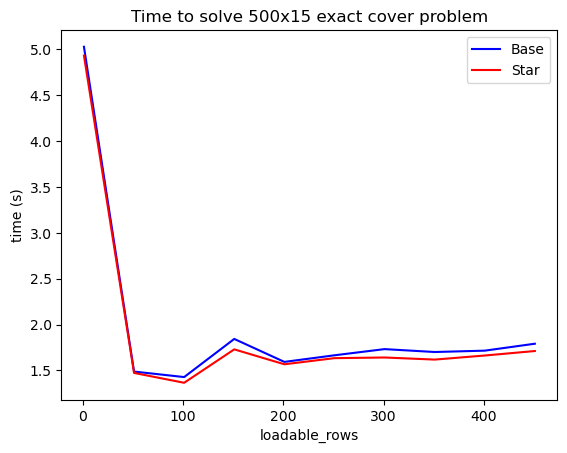

In [101]:
plot_time_to_solve()

loadable_rows = 451
Total columns: 15
Total rows: 500
Explored: 268616
#solutions: 2500
Total columns: 15
Total rows: 500
Explored: 268616
#solutions: 2500
loadable_rows = 401
Total columns: 15
Total rows: 500
Explored: 264060
#solutions: 2519
Total columns: 15
Total rows: 500
Explored: 264060
#solutions: 2519
loadable_rows = 351
Total columns: 15
Total rows: 500
Explored: 285364
#solutions: 2472
Total columns: 15
Total rows: 500
Explored: 285364
#solutions: 2472
loadable_rows = 301
Total columns: 15
Total rows: 500
Explored: 322128
#solutions: 2846
Total columns: 15
Total rows: 500
Explored: 322128
#solutions: 2846
loadable_rows = 251
Total columns: 15
Total rows: 500
Explored: 267332
#solutions: 2047
Total columns: 15
Total rows: 500
Explored: 267332
#solutions: 2047
loadable_rows = 201
Total columns: 15
Total rows: 500
Explored: 353367
#solutions: 3833
Total columns: 15
Total rows: 500
Explored: 353367
#solutions: 3833
loadable_rows = 151
Total columns: 15
Total rows: 500
Explored: 

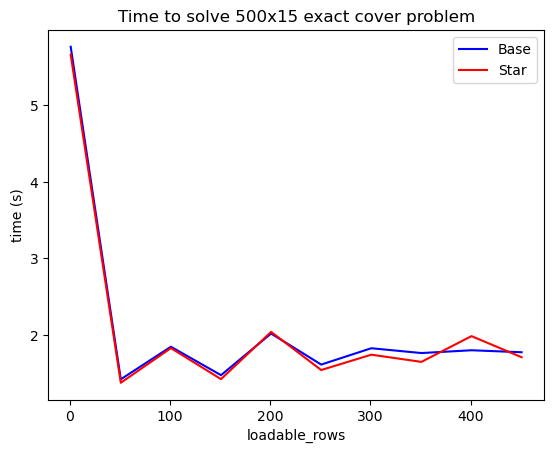

In [102]:
plot_time_to_solve(reverse=True)

### How do rows and columns affect the number of explored nodes?

In [48]:
# Creating different exact cover problems of rows from 20 to 100 of step 20
# and columns from 5 to 17 with step 3,
# so there are 25 different problems and each of them will have its number of explored nodes
# and its number of solutions

# Generating and solving the 25 exact cover problems
explored = []
solutions = []

times = []
times_star = []

min_rows = 20
max_rows = 500
step_rows = (max_rows - min_rows) // 5

min_cols = 5
max_cols = 20
step_cols = (max_cols - min_cols) // 5

row_values = range(min_rows, max_rows, step_rows)
col_values = range(min_cols, max_cols, step_cols)
problems = []
for rows in row_values:
    for cols in col_values:
        print(f"Generating exact cover problem with {rows} rows and {cols} columns")
        matrix = generate_exact_cover(rows, cols, path_out+"generated_exact_cover.txt")
        print("Solving...")
        start_star = time.time()
        sol, exp = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=1000, verbose=False, mode="star")
        end_star = time.time()
        start = time.time()
        sol, exp = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=1000, verbose=False)
        end = time.time()
        times.append(end - start)
        times_star.append(end_star - start_star)
        explored.append((rows, cols, len(exp)))
        solutions.append((rows, cols, len(sol)))

Generating exact cover problem with 20 rows and 5 columns
Solving...
Total columns: 5
Total rows: 20
Explored: 241
#solutions: 23
Total columns: 5
Total rows: 20
Explored: 241
#solutions: 23
Generating exact cover problem with 20 rows and 8 columns
Solving...
Total columns: 8
Total rows: 20
Explored: 430
#solutions: 15
Total columns: 8
Total rows: 20
Explored: 430
#solutions: 15
Generating exact cover problem with 20 rows and 11 columns
Solving...
Total columns: 11
Total rows: 20
Explored: 1786
#solutions: 14
Total columns: 11
Total rows: 20
Explored: 1786
#solutions: 14
Generating exact cover problem with 20 rows and 14 columns
Solving...
Total columns: 14
Total rows: 20
Explored: 9081
#solutions: 7
Total columns: 14
Total rows: 20
Explored: 9081
#solutions: 7
Generating exact cover problem with 20 rows and 17 columns
Solving...
Total columns: 17
Total rows: 20
Explored: 65847
#solutions: 4
Total columns: 17
Total rows: 20
Explored: 65847
#solutions: 4
Generating exact cover problem w

In [55]:
len(times)

25

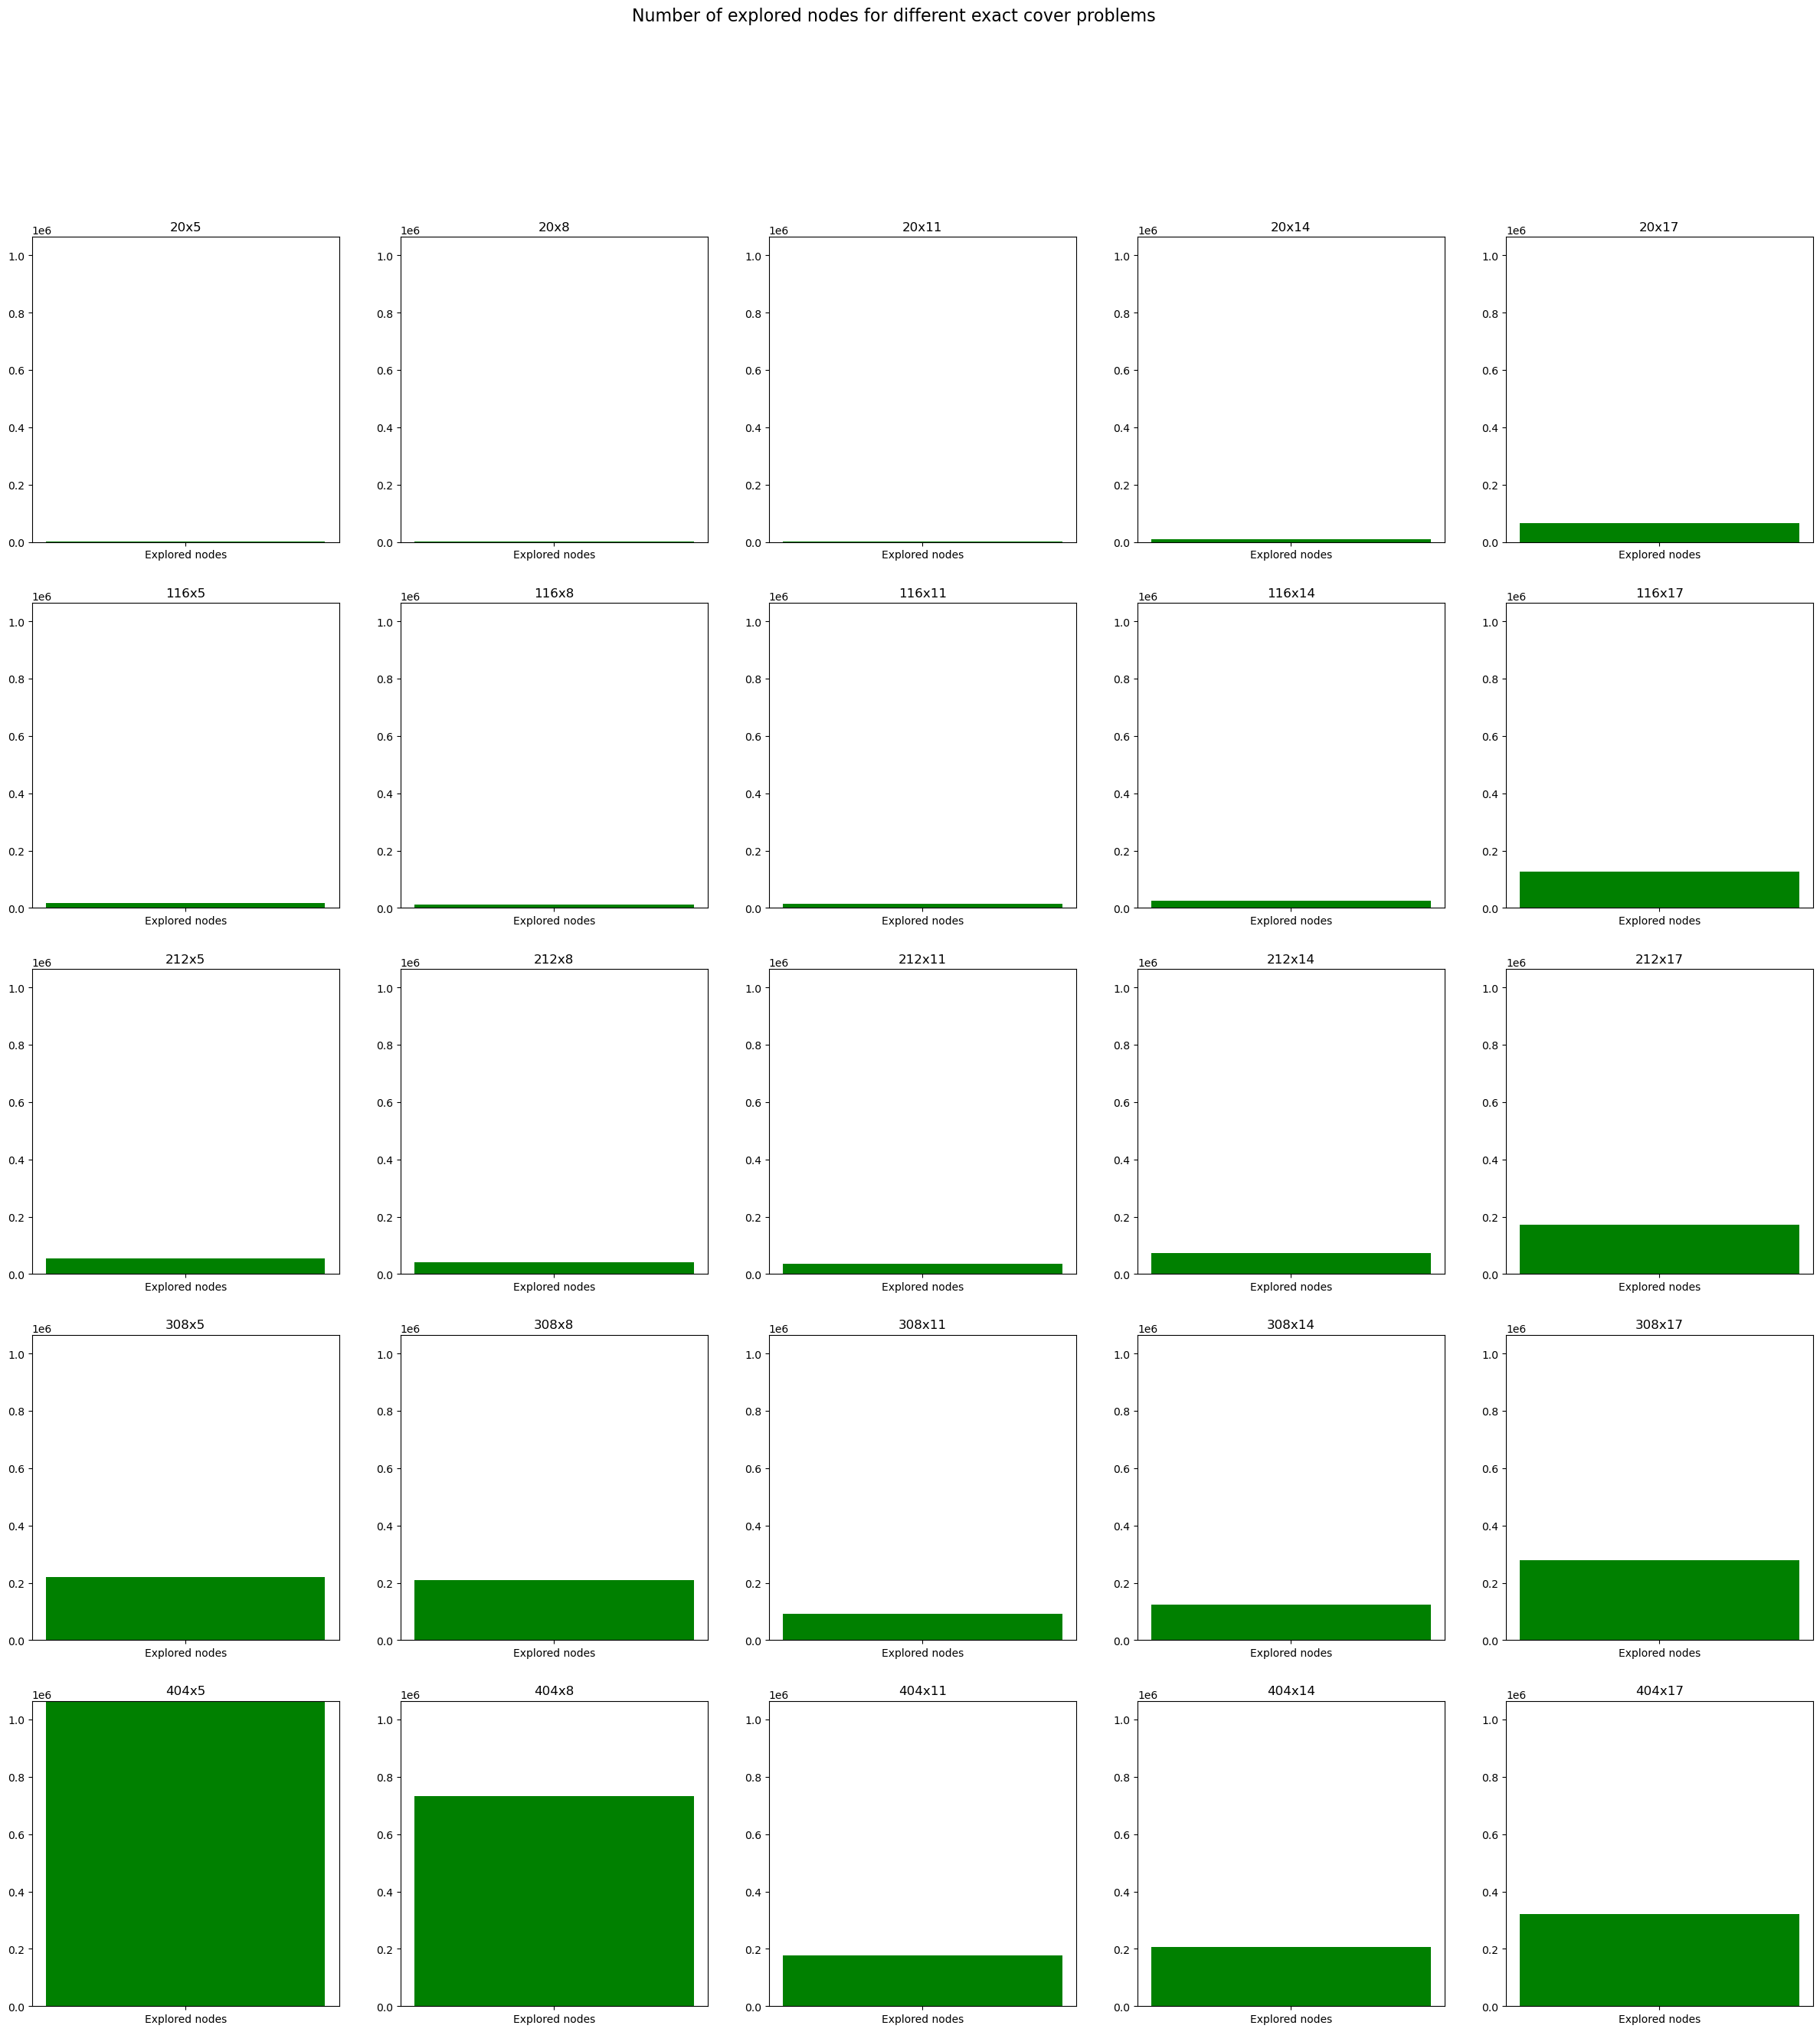

In [50]:
# Plotting the number of explored nodes
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for i, (rows, cols, exp) in enumerate(explored):
    ax = axs[i // 5][i % 5]
    # color red
    ax.bar(["Explored nodes"], [exp], color="green")
    ax.set_title(f"{rows}x{cols}")
    # ax.set_xlabel("Explored nodes")
    # ax.set_ylabel("Number of explored nodes")
    # Setting the y limit to the maximum number of explored nodes
    ax.set_ylim(top=max([exp for _, _, exp in explored]))
title = fig.suptitle("Number of explored nodes for different exact cover problems", fontsize=16)
plt.show()


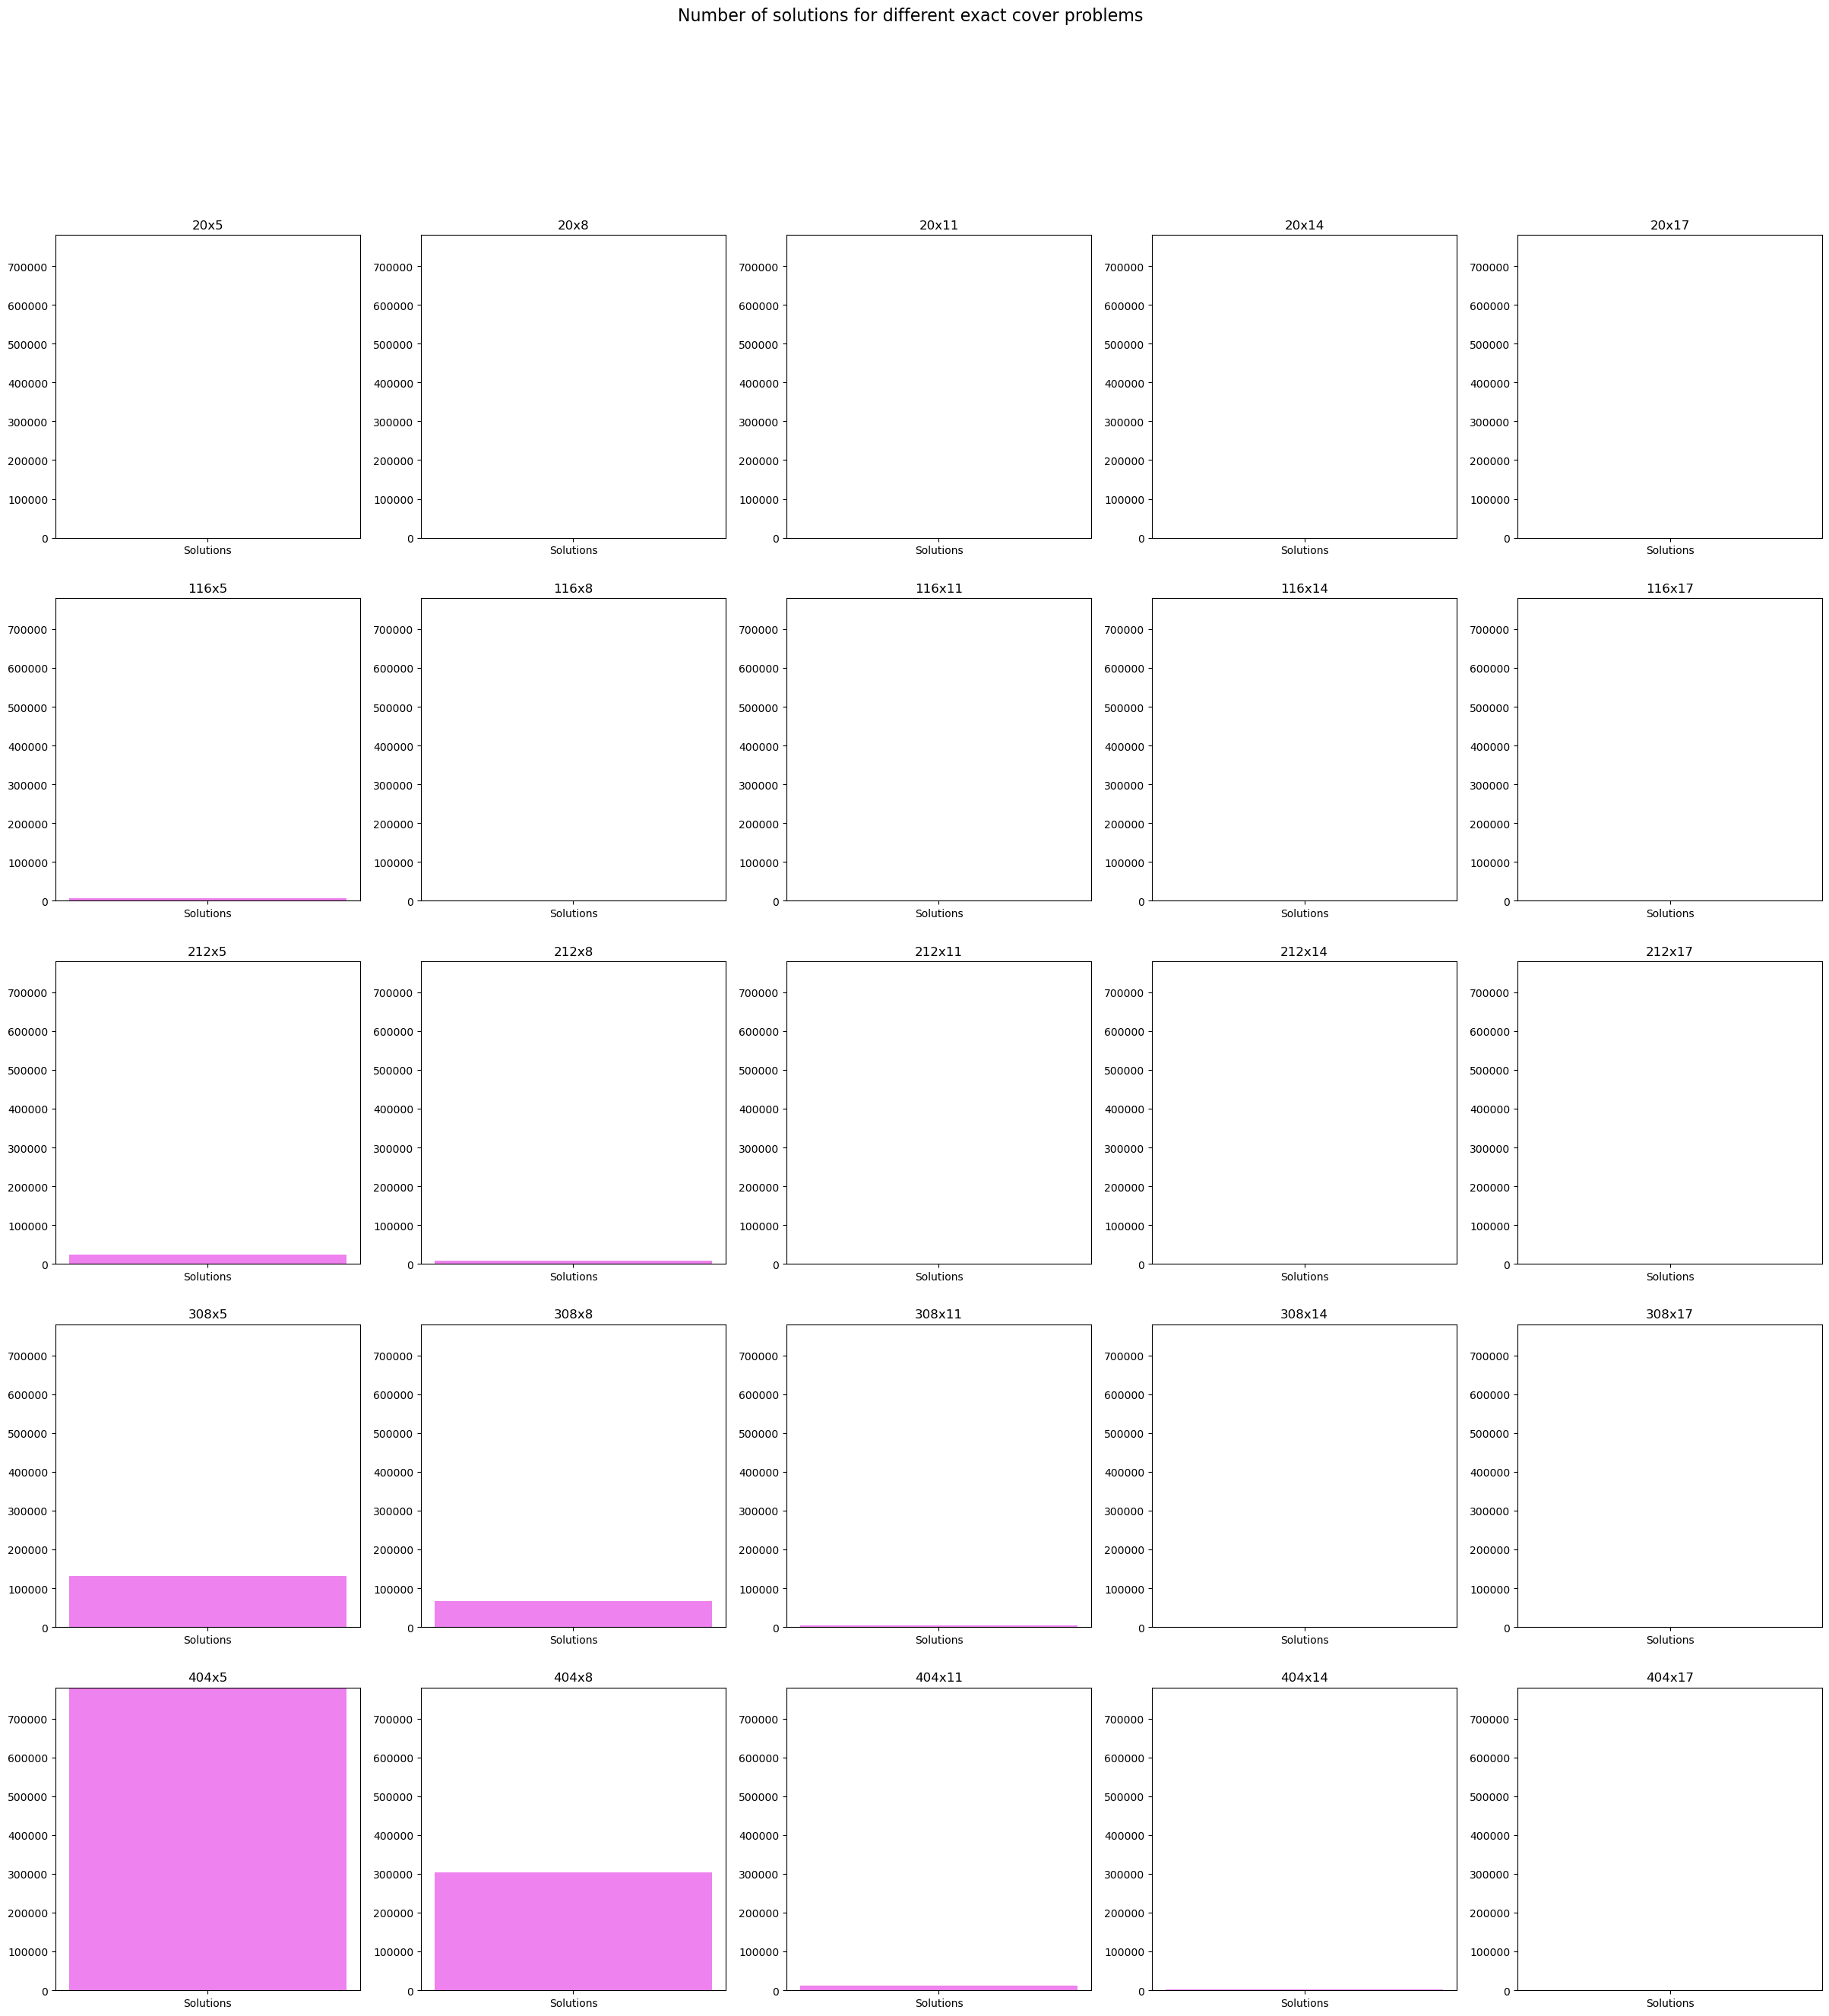

In [51]:

# Plotting the number of solutions
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for i, (rows, cols, sol) in enumerate(solutions):
    ax = axs[i // 5][i % 5]
    ax.bar(["Solutions"], [sol], color="violet")
    ax.set_title(f"{rows}x{cols}")
    # ax.set_xlabel("Solutions")
    # ax.set_ylabel("Number of solutions")
    # Setting the y limit to the maximum number of solutions
    ax.set_ylim(top=max([sol for _, _, sol in solutions]))
title = fig.suptitle("Number of solutions for different exact cover problems", fontsize=16)
plt.show()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


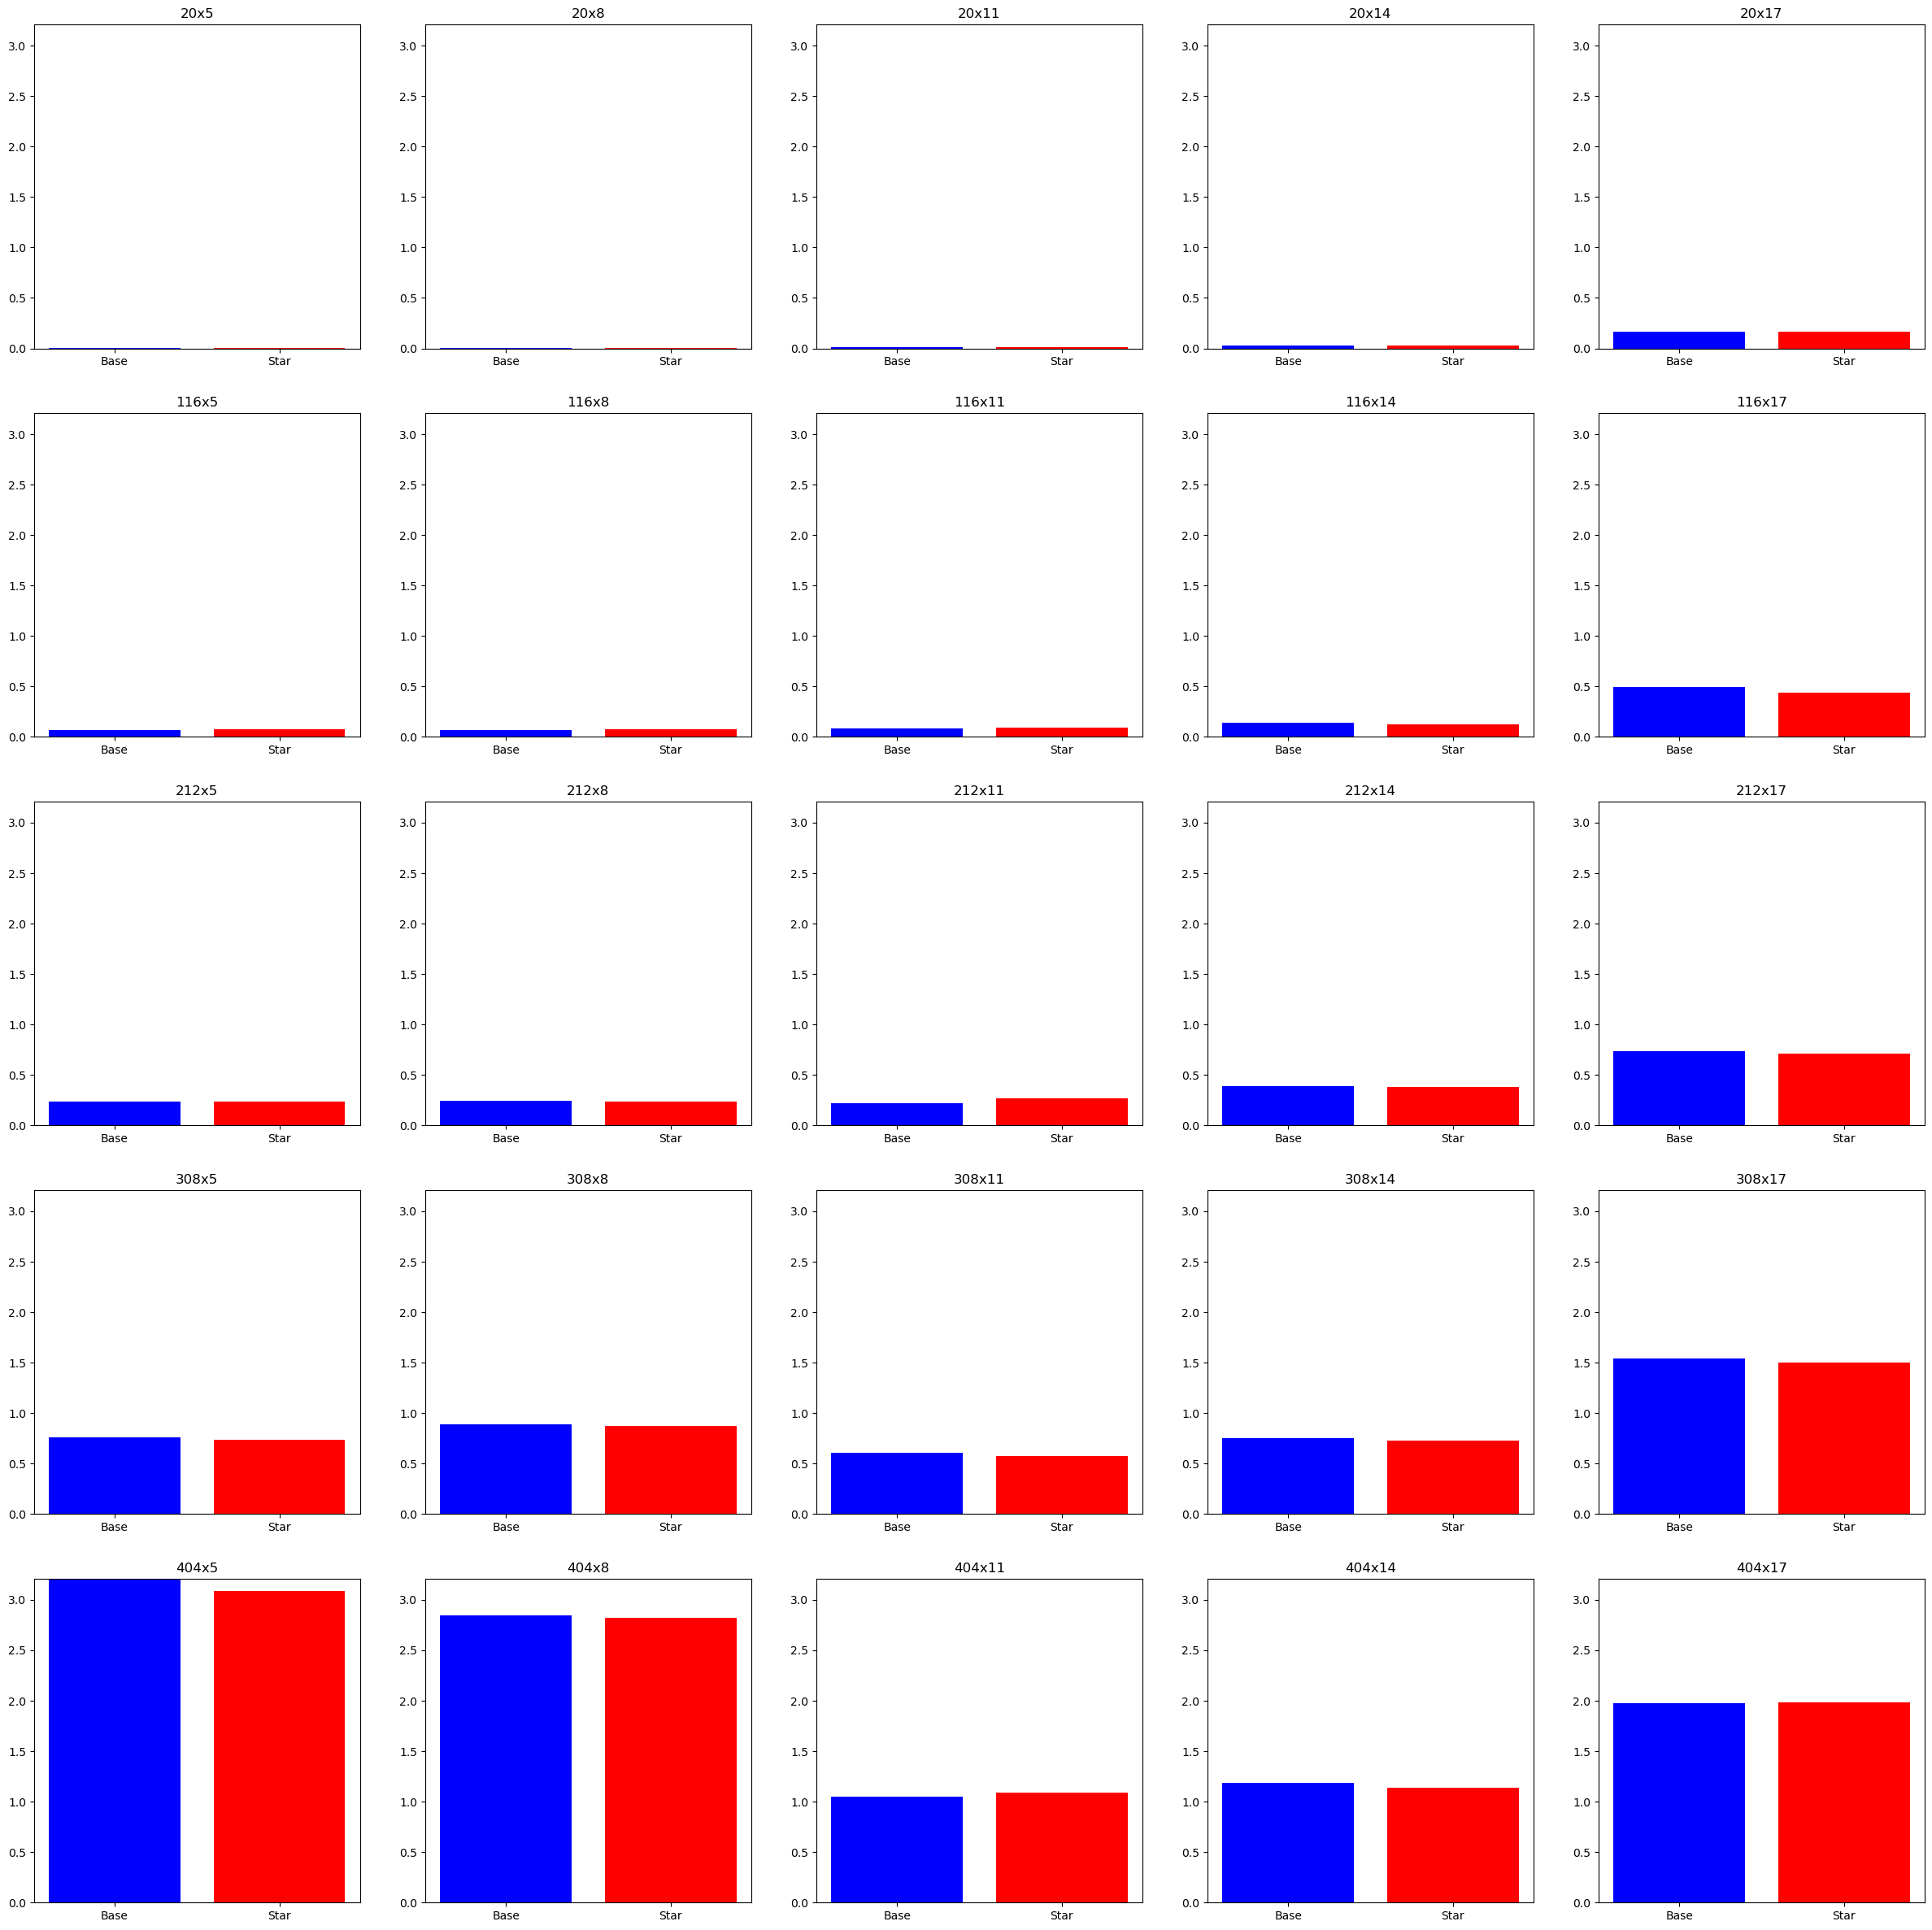

In [58]:

# Plotting the time to solve for base and star versions (bar charts)
fig, axs = plt.subplots(5, 5, figsize=(30, 30))
for i, (time, time_star, (rows, cols,_)) in enumerate(zip(times, times_star, solutions)):
    print(i)
    ax = axs[i // 5][i % 5]
    ax.bar(["Base", "Star"], [time, time_star], color=["blue", "red"])
    ax.set_title(f"{rows}x{cols}")
    # ax.set_xlabel("Version")
    # ax.set_ylabel("Time (s)")
    # Setting the y limit to the maximum time
    ax.set_ylim(top=max([time for time in times]))

In [103]:
# Generating an exact cover problem 400x15 and solving it
matrix = generate_exact_cover(1000, 15, path_out+"generated_exact_cover.txt")

In [105]:
%%time
print("Solving...")
%memit sol, exp = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=10, verbose=False, filename_out=path_out+"generated_exact_cover_out.txt")

Solving...
Total columns: 15
Total rows: 1000
Explored: 933208
#solutions: 11183
peak memory: 377.77 MiB, increment: 98.19 MiB
CPU times: user 7.22 s, sys: 508 ms, total: 7.73 s
Wall time: 7.88 s


In [106]:
%%time
# and with the star version
print("Solving...")
%memit sol, exp = incremental_exact_cover(filename=path_out+"generated_exact_cover.txt", loadable_rows=10, verbose=False, filename_out=path_out+"generated_exact_cover_out_star.txt", mode="star")

Solving...
Total columns: 15
Total rows: 1000
Explored: 933208
#solutions: 11183
peak memory: 377.75 MiB, increment: 2.88 MiB
CPU times: user 6.91 s, sys: 525 ms, total: 7.44 s
Wall time: 7.58 s
